In [1]:
# Pip imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import stan

try:
    import arviz as az
except ImportError as err:
    print("Please, install arviz for easy visualization of Stan models.")

import nest_asyncio
nest_asyncio.apply()

import pandas as pd

print(stan.__version__)

/home/krupkaa/anaconda3/envs/cognitive/lib/python3.12/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


3.10.0


In [2]:
stan_code = """

data {
    int<lower=1> N;
    //real tau_0;
    //real tau_1;
    //real sigma_a;
    //real sigma_b;
    matrix[N, 3] x;
    vector[N] y;
}

parameters {
    real<lower=0> sigma;
    real alpha;
    vector[3] beta;
}

//transformed parameters {
//  matrix[3, 3] I;
//
//  for(i in 1: 3){
//    for(j in 1:3){
//      if(i == j){
//        I[i, j] = 1.0;
//      }
//      else{
//        I[i, j] = 0.0;
//      }
//    }
//  }

//}

model {
    sigma ~ inv_gamma(0.1, 1);
    alpha ~ normal(0, 0.1);
    beta ~ normal(0, 1);

    // sigma ~ inv_gamma(tau_0, tau_1);
    // alpha ~ normal(0, sigma_a);
    // beta ~ multi_normal(rep_vector(0, 3), 1 * I);

    // y ~ multi_normal(x * beta, sigma);

    for (n in 1:N) {
        y[n] ~ normal(alpha + beta' * (x[n]'), sigma);
    }
}

generated quantities{
  array[N] real pred_distr;
  for(i in 1:N){
    pred_distr[i] = normal_rng(alpha + beta' * (x[i]'), sigma);
  }
}

"""

In [3]:
# Read in the file
insurance_data = pd.read_csv("insurance.csv")

insurance_data = insurance_data.sample(frac=1).reset_index(drop=True)

key_param_df = insurance_data[['age', 'bmi', 'children']].astype(np.float64)

# Standardize the data in these columns

for col in key_param_df:
    key_param_df[col] = (key_param_df[col] - key_param_df[col].mean())/(key_param_df[col].std())

# Also standardize the charges
insurance_data["charges"] = (insurance_data['charges'] - insurance_data['charges'].mean())/(insurance_data['charges'].std())

parameter_vals = key_param_df.values
charges_vals = insurance_data["charges"].values

num_rows = parameter_vals.shape[0]

split_proportion = 0.9
split_row = int(num_rows * split_proportion)

training_data_params = parameter_vals[split_row:, :]
testing_data_params = parameter_vals[:split_row, :]

training_data_charges = charges_vals[split_row:]
testing_data_charges = charges_vals[:split_row]

print(f"Shape of Total Data Set: {charges_vals.shape}")
print(f"Split Row: {split_row}")
print(f"Shape of Training Set: {training_data_charges.shape}")
print(f"Shape of Test Set: {testing_data_charges.shape}")

Shape of Total Data Set: (1338,)
Split Row: 1204
Shape of Training Set: (134,)
Shape of Test Set: (1204,)


In [4]:

data_dict = {
    'N': training_data_charges.shape[0],
    # 'tau_0': 0.3,
    # 'tau_1': 0.6,
    # 'sigma_a': 5,
    # 'sigma_b': 1,
    #'x': np.ndarray(key_param_df.values, dtype=float)
    'x': training_data_params,
    'y': training_data_charges
}

model = stan.build(stan_code, data=data_dict)

Building...



Building: 53.5s, done.Messages from stanc:
Warning in '/tmp/httpstan_ov_gwd35/model_4vpvidgz.stan', line 37, column 22: Argument
    0.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_ov_gwd35/model_4vpvidgz.stan', line 36, column 22: Argument
    0.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).


In [5]:
fit = model.sample(num_chains=4, num_samples=2000, num_warmup=1000)

Sampling:   0%
Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 0.000182 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.82 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000234 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00017 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.7 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00015 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.5 seconds.
  Adjust your expectations accordingly!


In [6]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.930,0.060,0.820,1.042,0.001,0.001,9224.0,6137.0,1.0
alpha,-0.064,0.063,-0.185,0.051,0.001,0.001,9475.0,6035.0,1.0
beta[0],0.212,0.090,0.041,0.376,0.001,0.001,9335.0,6474.0,1.0
beta[1],0.123,0.079,-0.024,0.268,0.001,0.001,9126.0,6077.0,1.0
beta[2],0.032,0.073,-0.108,0.169,0.001,0.001,9114.0,6069.0,1.0
...,...,...,...,...,...,...,...,...,...
pred_distr[129],0.085,0.969,-1.631,2.023,0.011,0.008,8102.0,7880.0,1.0
pred_distr[130],0.006,0.936,-1.825,1.715,0.011,0.008,7803.0,7785.0,1.0
pred_distr[131],0.142,0.947,-1.656,1.904,0.011,0.008,8125.0,7846.0,1.0
pred_distr[132],-0.202,0.943,-1.918,1.619,0.011,0.008,7918.0,7770.0,1.0


/home/krupkaa/anaconda3/envs/cognitive/lib/python3.12/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (139), generating only 20 plots
  warnings.warn(


array([[<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'beta\n0'}>],
       [<Axes: title={'center': 'beta\n1'}>,
        <Axes: title={'center': 'beta\n1'}>],
       [<Axes: title={'center': 'beta\n2'}>,
        <Axes: title={'center': 'beta\n2'}>],
       [<Axes: title={'center': 'pred_distr\n0'}>,
        <Axes: title={'center': 'pred_distr\n0'}>],
       [<Axes: title={'center': 'pred_distr\n1'}>,
        <Axes: title={'center': 'pred_distr\n1'}>],
       [<Axes: title={'center': 'pred_distr\n2'}>,
        <Axes: title={'center': 'pred_distr\n2'}>],
       [<Axes: title={'center': 'pred_distr\n3'}>,
        <Axes: title={'center': 'pred_distr\n3'}>],
       [<Axes: title={'center': 'pred_distr\n4'}>,
        <Axes: title={'center': 'pred_distr\n4'}>],
       [<Axes: title={'center': 'pred_

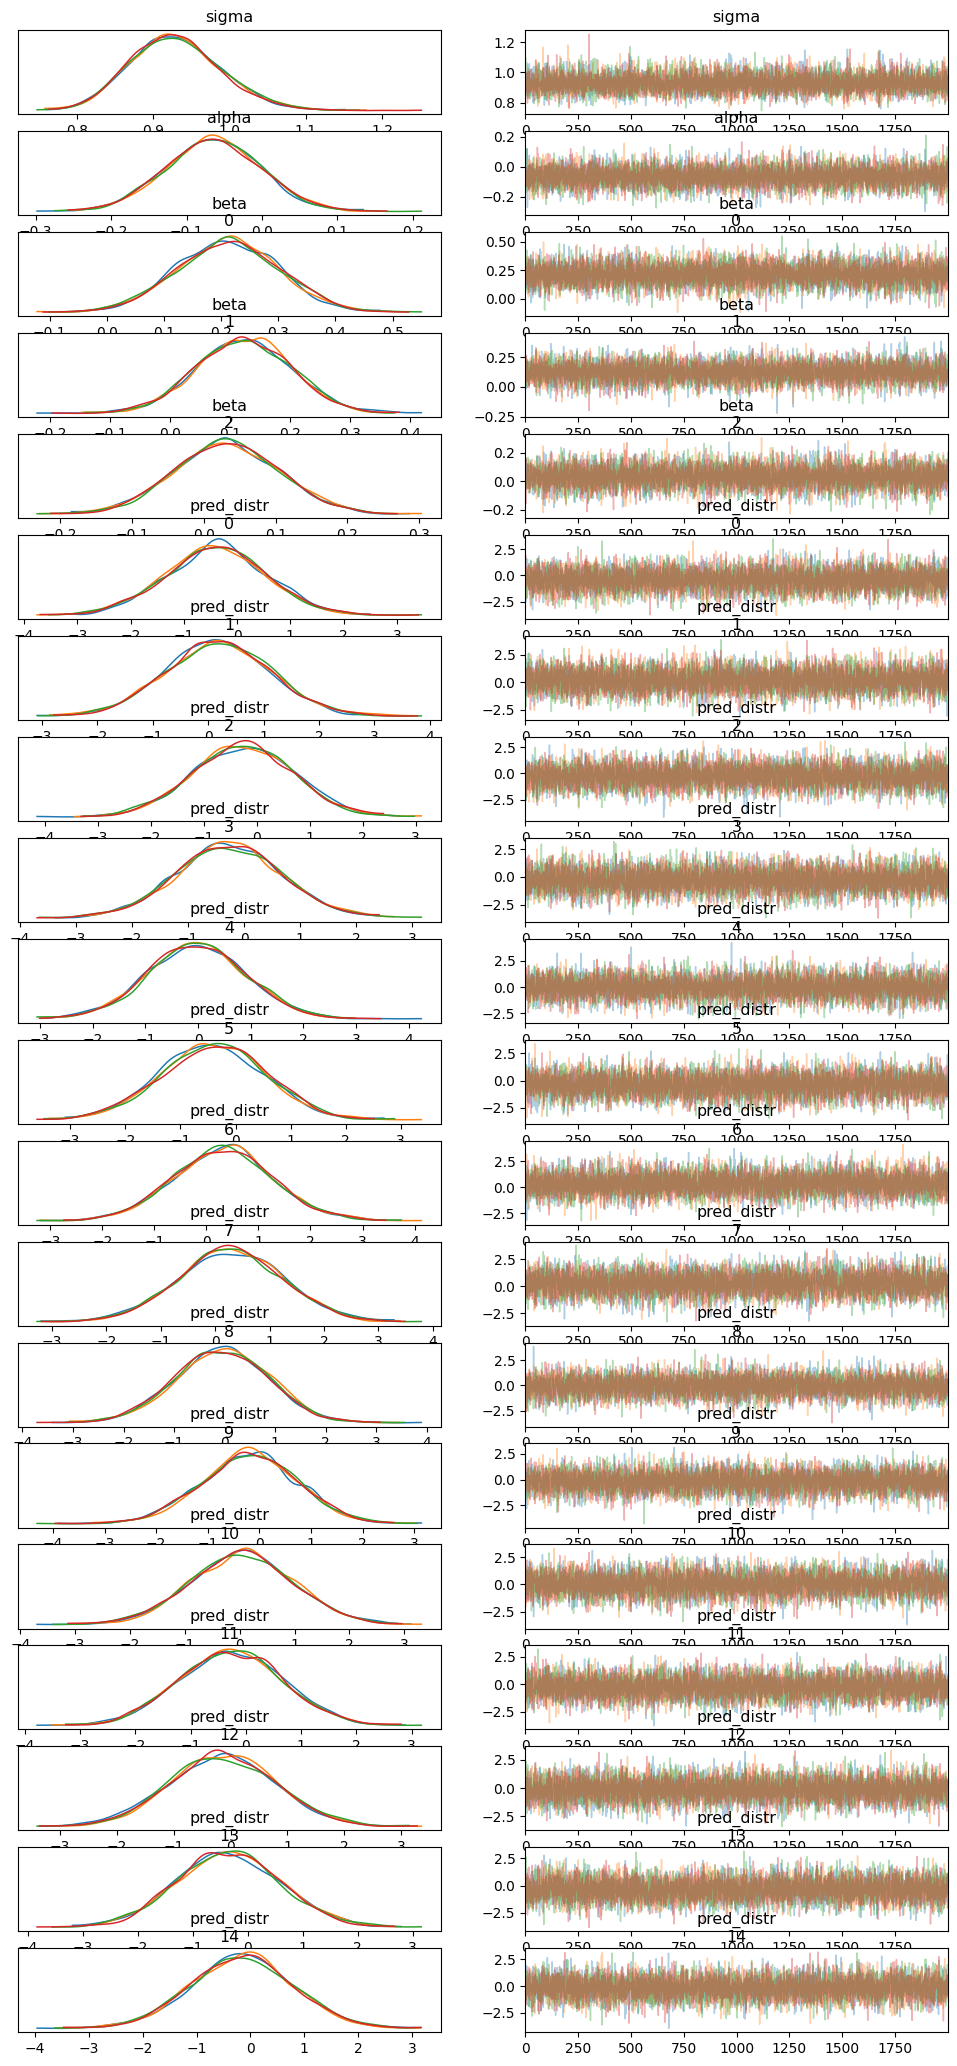

In [7]:
az.plot_trace(fit, compact=False, figsize=(12, 26))

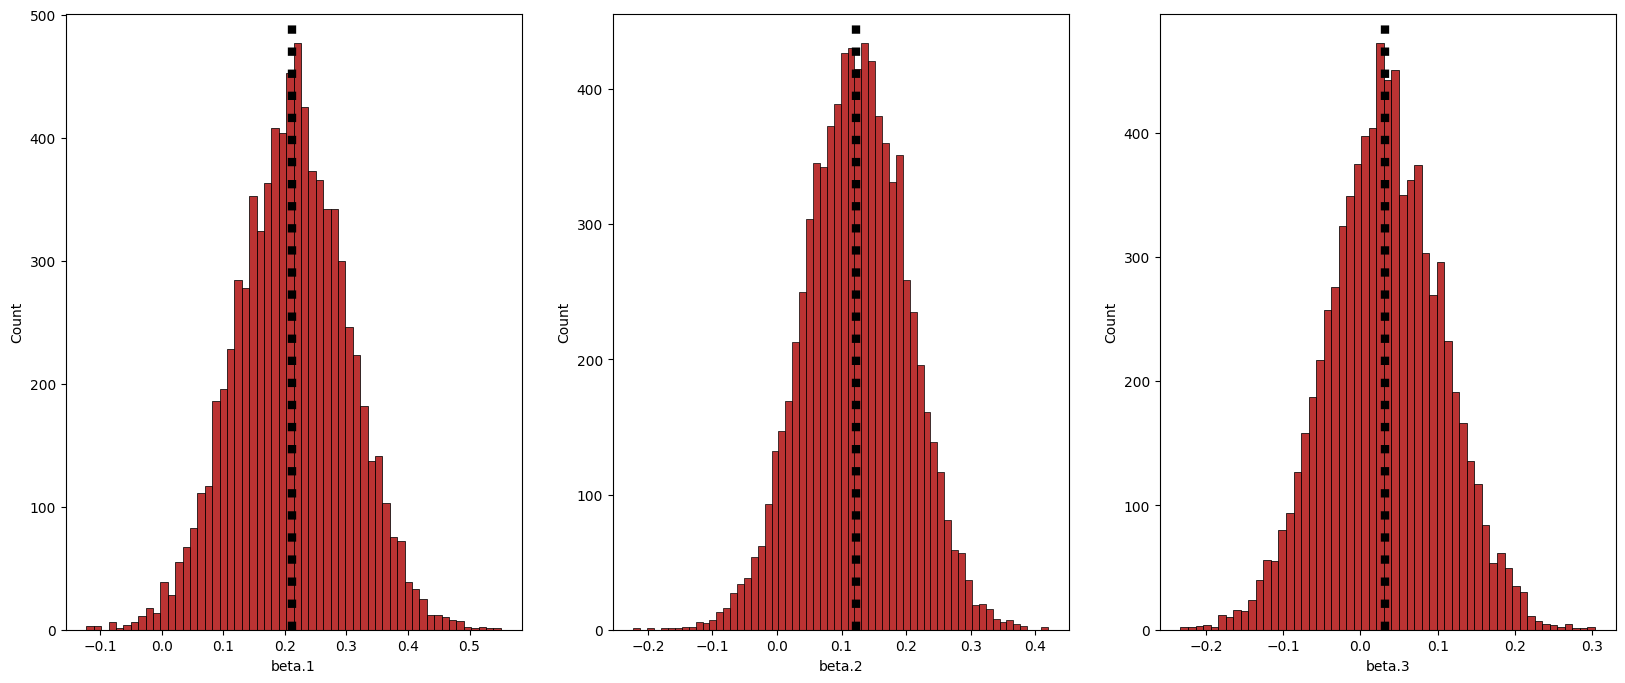

In [8]:
results_frame = fit.to_frame()

f, ax = plt.subplots(1, 3, figsize=(20, 8))

sns.histplot(results_frame, x='beta.1', ax = ax[0], color='#AA0000', alpha=0.8, lw=2)
sns.histplot(results_frame, x='beta.2', ax = ax[1], color='#AA0000', alpha=0.8, lw=2)
sns.histplot(results_frame, x='beta.3', ax = ax[2], color='#AA0000', alpha=0.8, lw=2)

ax[0].axvline(np.mean(results_frame['beta.1']), color='black', linestyle='dotted', lw=6)
ax[1].axvline(np.mean(results_frame['beta.2']), color='black', linestyle='dotted', lw=6)
ax[2].axvline(np.mean(results_frame['beta.3']), color='black', linestyle='dotted', lw=6)

### Problem 4

In [9]:
pred_distr = fit['pred_distr'] #Predictive distribution
num_samples = testing_data_charges.shape[0] #Nunmber of samples
pred_means = np.mean(pred_distr, axis=1) #Predictive distribution means
pred_samples = np.random.choice(pred_means, size=num_samples)

In [10]:
print (pred_samples.shape)
print (testing_data_charges.shape)

#Calculate the RMSE
rmse = np.sqrt((1/num_samples) * np.sum((pred_samples - testing_data_charges)**2))
print(f"RMSE = {rmse}")

(1204,)
(1204,)
RMSE = 1.035780629194934
